# This file is for random subset for part 3

In [1]:
import torchvision
import torch
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image
from matplotlib import pyplot as plt
from torchvision import transforms
import torch.optim as optim


/home/ruchitjagodara/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

torch.Size([400, 400, 3])


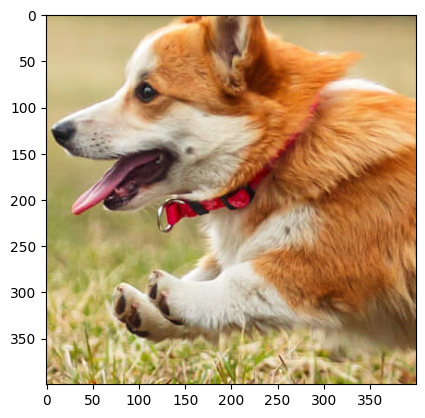

In [3]:
img = torchvision.io.read_image('dog.jpg').permute(1, 2, 0)

img = img[600:1000, 800:1200, :]

print(img.size())

img_array = np.array(img)

plt.imshow(img_array)

# Part 3

In [14]:
def least_squares(B, A):
    B = B.reshape(B.shape[0], 1)
    mask = ~torch.isnan(B)
    if (B.isnan().any()):
        A = A[torch.squeeze(mask)]
        B = B[torch.squeeze(mask)]

    return torch.linalg.lstsq(A, B, rcond=None).solution


def factorize(A, k, device, _):
    # Initialize W and H with random values between 0 and 255
    W = torch.randint(0, 256, (A.shape[0], k), dtype=torch.float32, device=device)
    H = torch.randint(0, 256, (k, A.shape[1]), dtype=torch.float32, device=device)

    for i in range(2):
        # Update H_n
        for i in range(A.shape[1]):
            A_col = A[:, i]
            H[:, i] = least_squares(A_col, W).reshape(k)
        # Update W_n
        for i in range(A.shape[0]):
            A_T_col = A[i, :]
            W[i, :] = least_squares(A_T_col, H.T).reshape(k)

        if (H.isnan().any()) or (W.isnan().any()):
            print("H or W has NaN")
            raise ValueError

    return W, H

# For N = 30

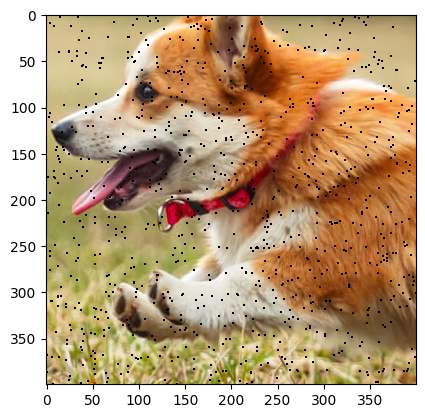

In [16]:
img_array = img.cpu().detach().to(dtype=torch.float32).numpy()
np.random.seed(42)
# Generate random indices for 900 points
random_indices = np.random.randint(0, img_array.shape[0], size=(900, 2))

# Set the selected points to NaN
img_array[random_indices[:, 0], random_indices[:, 1], :] = np.nan

# Display the modified image
plt.imshow(img_array / 255)
plt.show()

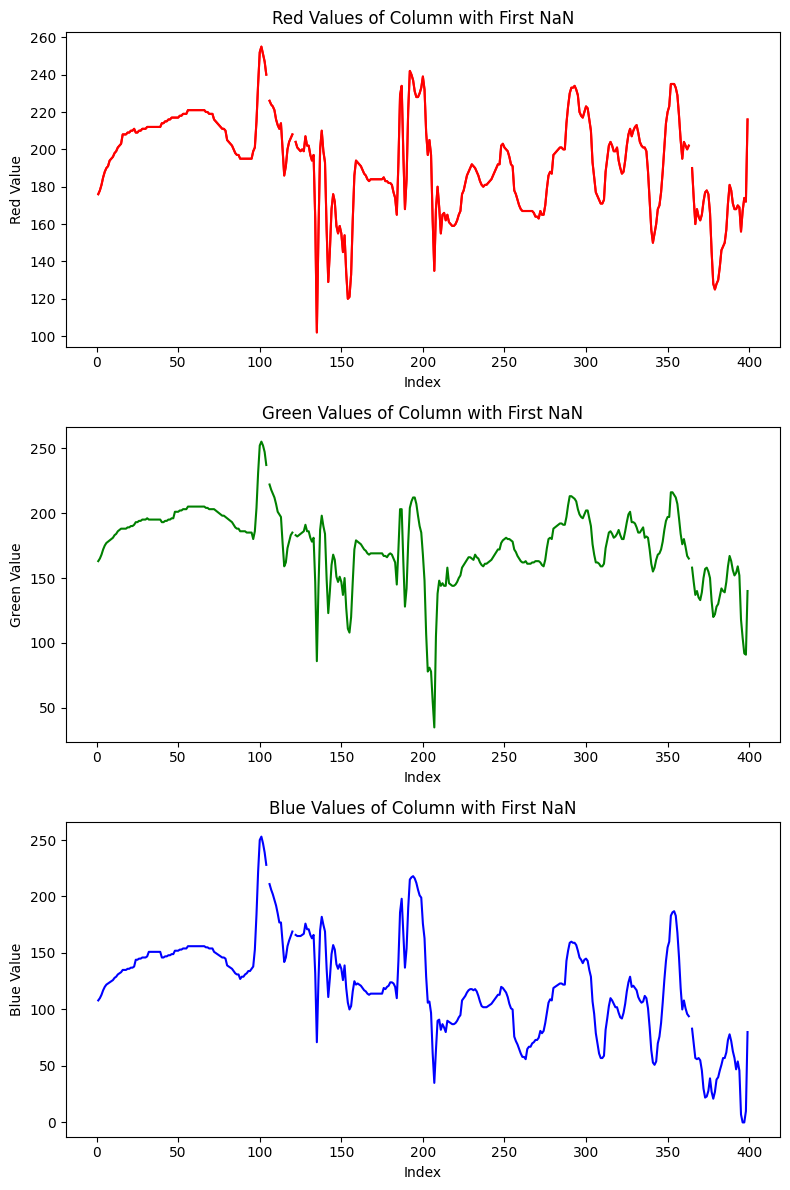

<Figure size 640x480 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt

# Find the column index where the first NaN value occurs
column_index = torch.where(torch.isnan(torch.tensor(img_array)))[1][0]

# Get the red values of the column
red_values = torch.tensor(img_array[:, column_index, 0])
# Get the green values of the column
green_values = torch.tensor(img_array[:, column_index, 1])
# Get the blue values of the column
blue_values = torch.tensor(img_array[:, column_index, 2])

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plot the red values
axs[0].plot(red_values, color='red')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Red Value')
axs[0].set_title('Red Values of Column with First NaN')
# Plot the red values with missing values as black
axs[0].plot(red_values, color='red')
axs[0].scatter(torch.where(torch.isnan(red_values))[0], red_values[torch.isnan(red_values)], color='black')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Red Value')
axs[0].set_title('Red Values of Column with First NaN')

# Plot the green values with missing values as black
axs[1].plot(green_values, color='green')
axs[1].scatter(torch.where(torch.isnan(green_values))[0], green_values[torch.isnan(green_values)], color='black')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Green Value')
axs[1].set_title('Green Values of Column with First NaN')

# Plot the blue values with missing values as black
axs[2].plot(blue_values, color='blue')
axs[2].scatter(torch.where(torch.isnan(blue_values))[0], blue_values[torch.isnan(blue_values)], color='black')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Blue Value')
axs[2].set_title('Blue Values of Column with First NaN')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

# Plot the green values
axs[1].plot(green_values, color='green')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Green Value')
axs[1].set_title('Green Values of Column with First NaN')

# Plot the blue values
axs[2].plot(blue_values, color='blue')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Blue Value')
axs[2].set_title('Blue Values of Column with First NaN')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


In [18]:
## for 1 colour train the model

A = torch.tensor(img_array).clone().detach().to(torch.float32).to(device)
k = 100     # Here, k should be very very small than A.shape[0] and A.shape[1] 
lambda_reg = 0.12  # here this is not being used anywhere

# Factorize each color channel separately
W_r, H_r = factorize(A[:, :, 0], k, device, lambda_reg)
W_g, H_g = factorize(A[:, :, 1], k, device, lambda_reg)
W_b, H_b = factorize(A[:, :, 2], k, device, lambda_reg)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


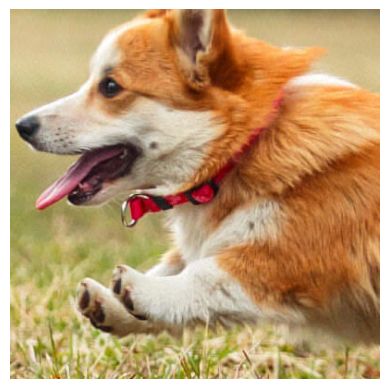

In [19]:
# Plot the reconstructed image

# Multiply W_r with H_r for the red channel
red_img = W_r @ H_r

# Multiply W_g with H_g for the green channel
green_img = W_g @ H_g

# Multiply W_b with H_b for the blue channel
blue_img = W_b @ H_b

# Combine the red, green, and blue channels to form the final image
final_img = np.stack([red_img.cpu().detach().numpy(), green_img.cpu().detach().numpy(), blue_img.cpu().detach().numpy()], axis=-1)

# Display the image
plt.imshow(final_img/255)
plt.axis('off')
plt.show()


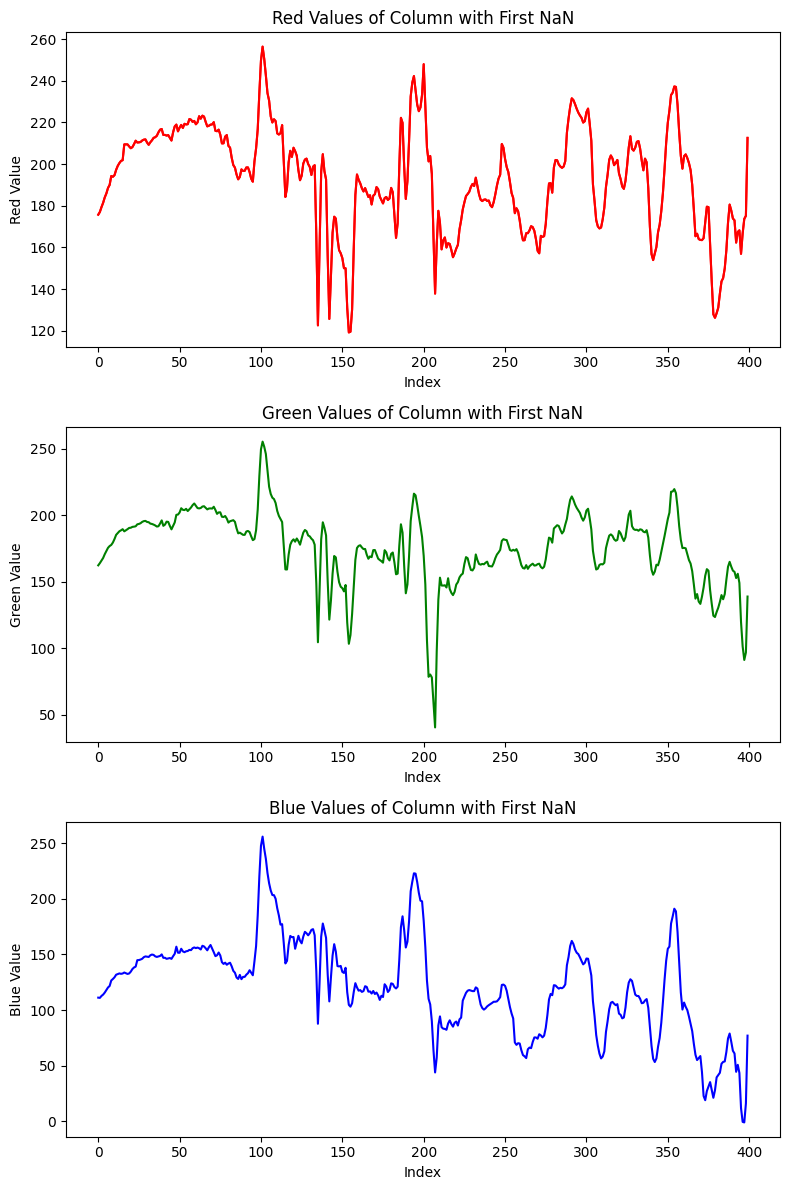

<Figure size 640x480 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt

# Find the column index where the first NaN value occurs
column_index = torch.where(torch.isnan(torch.tensor(img_array)))[1][0]

# Get the red values of the column
red_values = (red_img[:, column_index]).cpu().detach().numpy()
# Get the green values of the column
green_values = (green_img[:, column_index]).cpu().detach().numpy()
# Get the blue values of the column
blue_values = (blue_img[:, column_index]).cpu().detach().numpy()

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plot the red values
axs[0].plot(red_values, color='red')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Red Value')
axs[0].set_title('Red Values of Column with First NaN')
# Plot the red values with missing values as black
axs[0].plot(red_values, color='red')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Red Value')
axs[0].set_title('Red Values of Column with First NaN')

# Plot the green values with missing values as black
axs[1].plot(green_values, color='green')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Green Value')
axs[1].set_title('Green Values of Column with First NaN')

# Plot the blue values with missing values as black
axs[2].plot(blue_values, color='blue')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Blue Value')
axs[2].set_title('Blue Values of Column with First NaN')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

# Plot the green values
axs[1].plot(green_values, color='green')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Green Value')
axs[1].set_title('Green Values of Column with First NaN')

# Plot the blue values
axs[2].plot(blue_values, color='blue')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Blue Value')
axs[2].set_title('Blue Values of Column with First NaN')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


# Metrics:

In [23]:
import numpy as np

# Convert the predicted image (A) and the original image (img) to numpy arrays
predicted_image = final_img
original_image = img.detach().cpu().numpy()

# Calculate the squared difference between the predicted and original images
squared_diff = np.square(predicted_image - original_image)

# Calculate the mean squared difference
mean_squared_diff = np.mean(squared_diff)

# Calculate the RMSE by taking the square root of the mean squared difference
rmse = np.sqrt(mean_squared_diff)

# Print the RMSE
print("RMSE:", rmse)


RMSE: 3.2063484


In [24]:
import numpy as np

def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    max_pixel = np.max(img1)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

psnr = calculate_psnr(final_img, np.array(img))
print("Peak Signal-to-Noise Ratio (PSNR):", psnr)


Peak Signal-to-Noise Ratio (PSNR): 38.26841354370117


# N = 20

# For 1 Colour

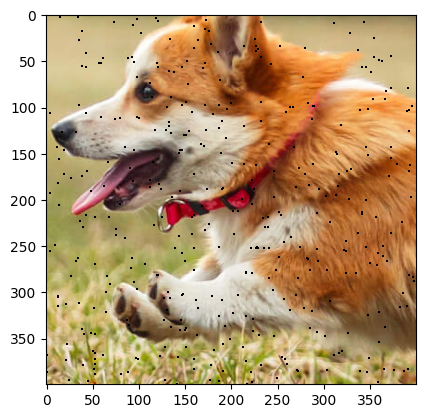

In [25]:
img_array = img.cpu().detach().to(dtype=torch.float32).numpy()
np.random.seed(42)
# Generate random indices for 900 points
random_indices = np.random.randint(0, img_array.shape[0], size=(400, 2))

# Set the selected points to NaN
img_array[random_indices[:, 0], random_indices[:, 1], :] = np.nan

# Display the modified image
plt.imshow(img_array / 255)
plt.show()

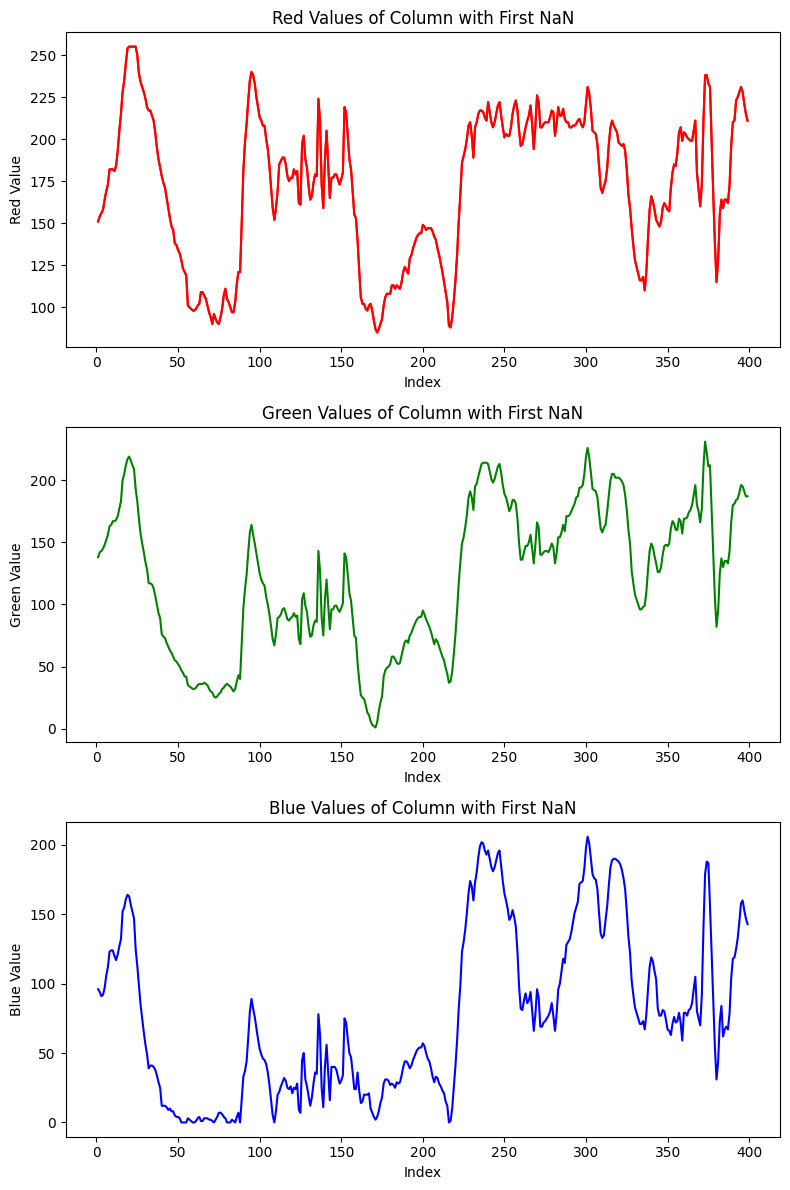

<Figure size 640x480 with 0 Axes>

In [26]:
import matplotlib.pyplot as plt

# Find the column index where the first NaN value occurs
column_index = torch.where(torch.isnan(torch.tensor(img_array)))[1][0]

# Get the red values of the column
red_values = torch.tensor(img_array[:, column_index, 0])
# Get the green values of the column
green_values = torch.tensor(img_array[:, column_index, 1])
# Get the blue values of the column
blue_values = torch.tensor(img_array[:, column_index, 2])

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plot the red values
axs[0].plot(red_values, color='red')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Red Value')
axs[0].set_title('Red Values of Column with First NaN')
# Plot the red values with missing values as black
axs[0].plot(red_values, color='red')
axs[0].scatter(torch.where(torch.isnan(red_values))[0], red_values[torch.isnan(red_values)], color='black')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Red Value')
axs[0].set_title('Red Values of Column with First NaN')

# Plot the green values with missing values as black
axs[1].plot(green_values, color='green')
axs[1].scatter(torch.where(torch.isnan(green_values))[0], green_values[torch.isnan(green_values)], color='black')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Green Value')
axs[1].set_title('Green Values of Column with First NaN')

# Plot the blue values with missing values as black
axs[2].plot(blue_values, color='blue')
axs[2].scatter(torch.where(torch.isnan(blue_values))[0], blue_values[torch.isnan(blue_values)], color='black')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Blue Value')
axs[2].set_title('Blue Values of Column with First NaN')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

# Plot the green values
axs[1].plot(green_values, color='green')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Green Value')
axs[1].set_title('Green Values of Column with First NaN')

# Plot the blue values
axs[2].plot(blue_values, color='blue')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Blue Value')
axs[2].set_title('Blue Values of Column with First NaN')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


In [32]:
## for 1 colour train the model

A = torch.tensor(img_array).clone().detach().to(torch.float32).to(device)
k = 180     # Here, k should be very very small than A.shape[0] and A.shape[1] 
lambda_reg = 0.12  # regularization parameter

# Factorize each color channel separately
W_r, H_r = factorize(A[:, :, 0], k, device, lambda_reg)
W_g, H_g = factorize(A[:, :, 1], k, device, lambda_reg)
W_b, H_b = factorize(A[:, :, 2], k, device, lambda_reg)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


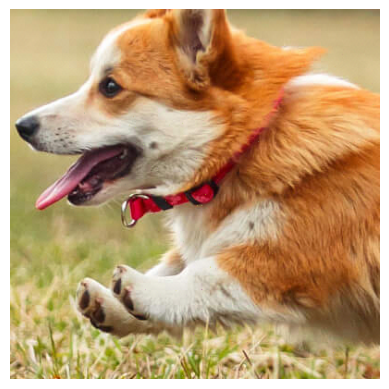

In [33]:
# Plot the reconstructed image

# Multiply W_r with H_r for the red channel
red_img = W_r @ H_r

# Multiply W_g with H_g for the green channel
green_img = W_g @ H_g

# Multiply W_b with H_b for the blue channel
blue_img = W_b @ H_b

# Combine the red, green, and blue channels to form the final image
final_img = np.stack([red_img.cpu().detach().numpy(), green_img.cpu().detach().numpy(), blue_img.cpu().detach().numpy()], axis=-1)

# Display the image
plt.imshow(final_img/255)
plt.axis('off')
plt.show()


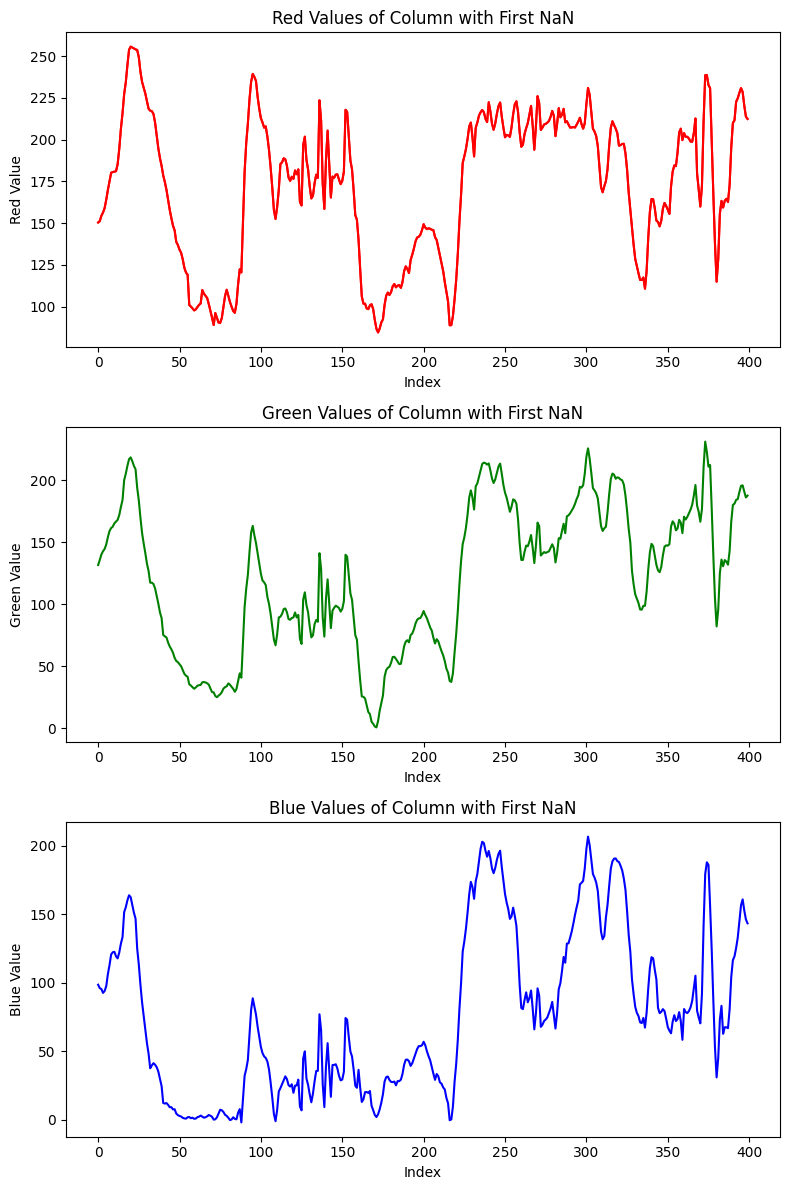

<Figure size 640x480 with 0 Axes>

In [34]:
import matplotlib.pyplot as plt

# Find the column index where the first NaN value occurs
column_index = torch.where(torch.isnan(torch.tensor(img_array)))[1][0]

# Get the red values of the column
red_values = (red_img[:, column_index]).cpu().detach().numpy()
# Get the green values of the column
green_values = (green_img[:, column_index]).cpu().detach().numpy()
# Get the blue values of the column
blue_values = (blue_img[:, column_index]).cpu().detach().numpy()

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plot the red values
axs[0].plot(red_values, color='red')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Red Value')
axs[0].set_title('Red Values of Column with First NaN')
# Plot the red values with missing values as black
axs[0].plot(red_values, color='red')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Red Value')
axs[0].set_title('Red Values of Column with First NaN')

# Plot the green values with missing values as black
axs[1].plot(green_values, color='green')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Green Value')
axs[1].set_title('Green Values of Column with First NaN')

# Plot the blue values with missing values as black
axs[2].plot(blue_values, color='blue')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Blue Value')
axs[2].set_title('Blue Values of Column with First NaN')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

# Plot the green values
axs[1].plot(green_values, color='green')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Green Value')
axs[1].set_title('Green Values of Column with First NaN')

# Plot the blue values
axs[2].plot(blue_values, color='blue')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Blue Value')
axs[2].set_title('Blue Values of Column with First NaN')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


# Metrics:

In [35]:
import numpy as np

# Convert the predicted image (A) and the original image (img) to numpy arrays
predicted_image = final_img
original_image = img.detach().cpu().numpy()

# Calculate the squared difference between the predicted and original images
squared_diff = np.square(predicted_image - original_image)

# Calculate the mean squared difference
mean_squared_diff = np.mean(squared_diff)

# Calculate the RMSE by taking the square root of the mean squared difference
rmse = np.sqrt(mean_squared_diff)

# Print the RMSE
print("RMSE:", rmse)


RMSE: 1.1289085


In [36]:
import numpy as np

def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    max_pixel = np.max(img1)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

psnr = calculate_psnr(final_img, np.array(img))
print("Peak Signal-to-Noise Ratio (PSNR):", psnr)


Peak Signal-to-Noise Ratio (PSNR): 47.213096618652344


# For N = 40

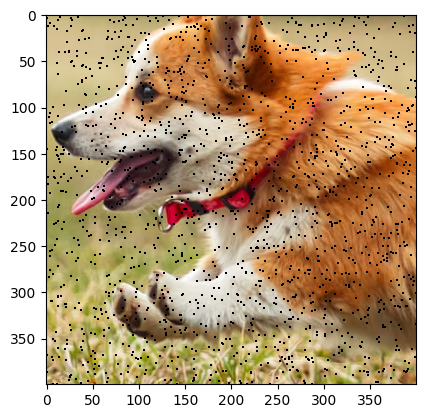

In [38]:
img_array = img.cpu().detach().to(dtype=torch.float32).numpy()
np.random.seed(42)
# Generate random indices for 900 points
random_indices = np.random.randint(0, img_array.shape[0], size=(1600, 2))

# Set the selected points to NaN
img_array[random_indices[:, 0], random_indices[:, 1], :] = np.nan

# Display the modified image
plt.imshow(img_array / 255)
plt.show()

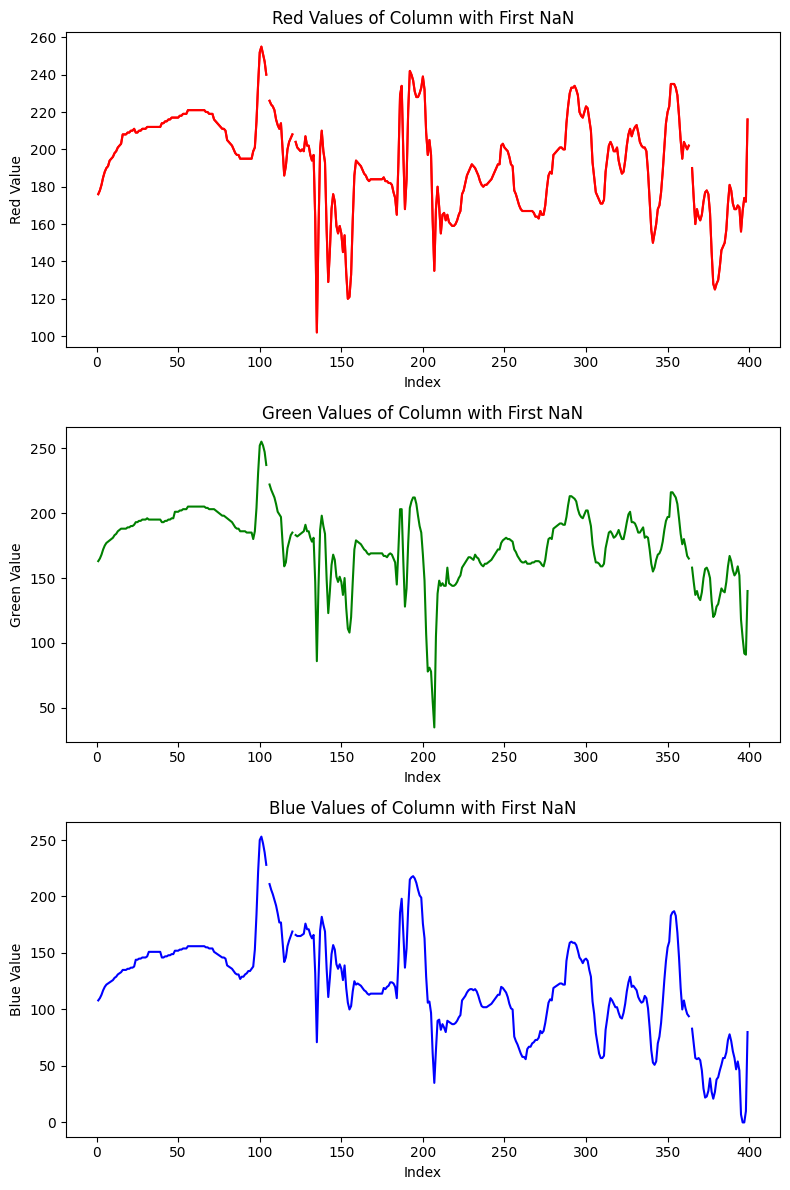

<Figure size 640x480 with 0 Axes>

In [39]:
import matplotlib.pyplot as plt

# Find the column index where the first NaN value occurs
column_index = torch.where(torch.isnan(torch.tensor(img_array)))[1][0]

# Get the red values of the column
red_values = torch.tensor(img_array[:, column_index, 0])
# Get the green values of the column
green_values = torch.tensor(img_array[:, column_index, 1])
# Get the blue values of the column
blue_values = torch.tensor(img_array[:, column_index, 2])

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plot the red values
axs[0].plot(red_values, color='red')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Red Value')
axs[0].set_title('Red Values of Column with First NaN')
# Plot the red values with missing values as black
axs[0].plot(red_values, color='red')
axs[0].scatter(torch.where(torch.isnan(red_values))[0], red_values[torch.isnan(red_values)], color='black')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Red Value')
axs[0].set_title('Red Values of Column with First NaN')

# Plot the green values with missing values as black
axs[1].plot(green_values, color='green')
axs[1].scatter(torch.where(torch.isnan(green_values))[0], green_values[torch.isnan(green_values)], color='black')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Green Value')
axs[1].set_title('Green Values of Column with First NaN')

# Plot the blue values with missing values as black
axs[2].plot(blue_values, color='blue')
axs[2].scatter(torch.where(torch.isnan(blue_values))[0], blue_values[torch.isnan(blue_values)], color='black')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Blue Value')
axs[2].set_title('Blue Values of Column with First NaN')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

# Plot the green values
axs[1].plot(green_values, color='green')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Green Value')
axs[1].set_title('Green Values of Column with First NaN')

# Plot the blue values
axs[2].plot(blue_values, color='blue')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Blue Value')
axs[2].set_title('Blue Values of Column with First NaN')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


In [40]:
## for 1 colour train the model

A = torch.tensor(img_array).clone().detach().to(torch.float32).to(device)
k = 180     # Here, k should be very very small than A.shape[0] and A.shape[1] 
lambda_reg = 0.12  # regularization parameter

# Factorize each color channel separately
W_r, H_r = factorize(A[:, :, 0], k, device, lambda_reg)
W_g, H_g = factorize(A[:, :, 1], k, device, lambda_reg)
W_b, H_b = factorize(A[:, :, 2], k, device, lambda_reg)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


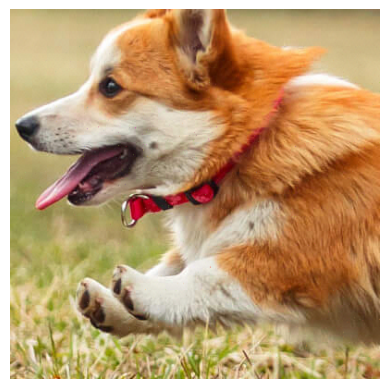

In [41]:
# Plot the reconstructed image

# Multiply W_r with H_r for the red channel
red_img = W_r @ H_r

# Multiply W_g with H_g for the green channel
green_img = W_g @ H_g

# Multiply W_b with H_b for the blue channel
blue_img = W_b @ H_b

# Combine the red, green, and blue channels to form the final image
final_img = np.stack([red_img.cpu().detach().numpy(), green_img.cpu().detach().numpy(), blue_img.cpu().detach().numpy()], axis=-1)

# Display the image
plt.imshow(final_img/255)
plt.axis('off')
plt.show()


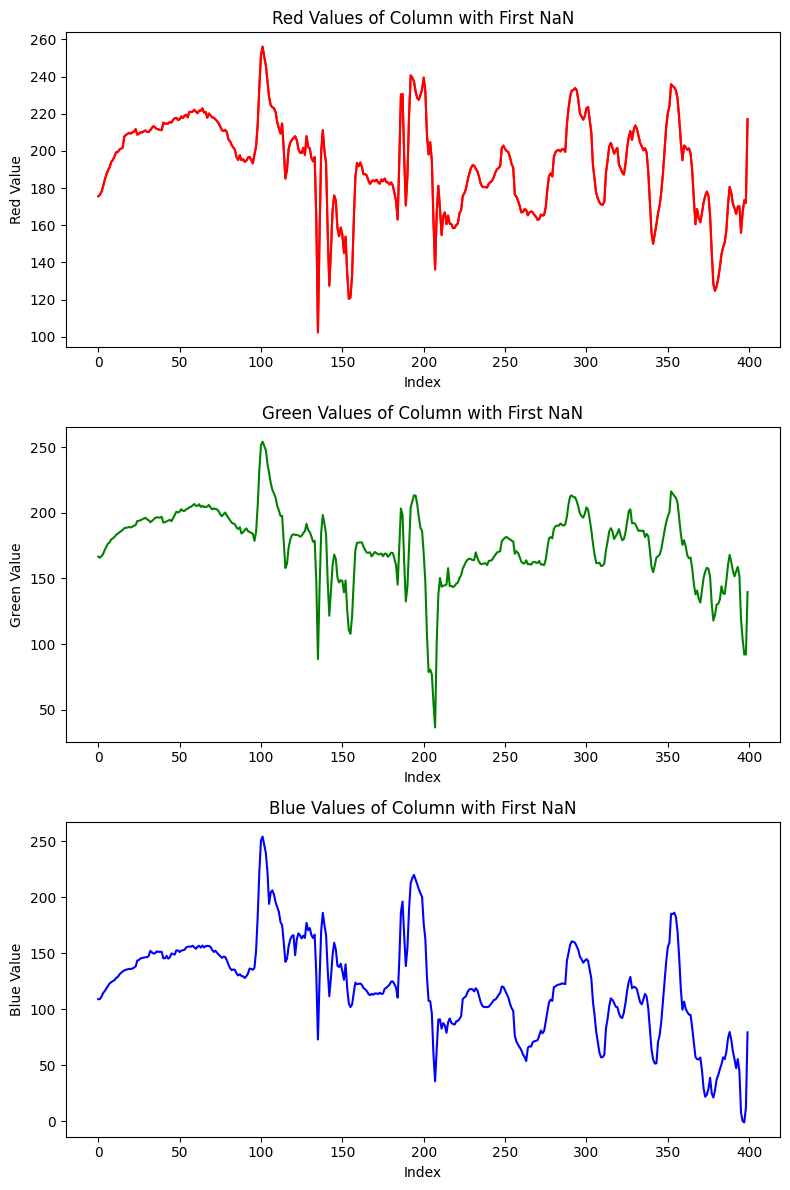

<Figure size 640x480 with 0 Axes>

In [42]:
import matplotlib.pyplot as plt

# Find the column index where the first NaN value occurs
column_index = torch.where(torch.isnan(torch.tensor(img_array)))[1][0]

# Get the red values of the column
red_values = (red_img[:, column_index]).cpu().detach().numpy()
# Get the green values of the column
green_values = (green_img[:, column_index]).cpu().detach().numpy()
# Get the blue values of the column
blue_values = (blue_img[:, column_index]).cpu().detach().numpy()

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plot the red values
axs[0].plot(red_values, color='red')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Red Value')
axs[0].set_title('Red Values of Column with First NaN')
# Plot the red values with missing values as black
axs[0].plot(red_values, color='red')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Red Value')
axs[0].set_title('Red Values of Column with First NaN')

# Plot the green values with missing values as black
axs[1].plot(green_values, color='green')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Green Value')
axs[1].set_title('Green Values of Column with First NaN')

# Plot the blue values with missing values as black
axs[2].plot(blue_values, color='blue')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Blue Value')
axs[2].set_title('Blue Values of Column with First NaN')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

# Plot the green values
axs[1].plot(green_values, color='green')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Green Value')
axs[1].set_title('Green Values of Column with First NaN')

# Plot the blue values
axs[2].plot(blue_values, color='blue')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Blue Value')
axs[2].set_title('Blue Values of Column with First NaN')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


# Metrics:

In [43]:
import numpy as np

# Convert the predicted image (A) and the original image (img) to numpy arrays
predicted_image = final_img
original_image = img.detach().cpu().numpy()

# Calculate the squared difference between the predicted and original images
squared_diff = np.square(predicted_image - original_image)

# Calculate the mean squared difference
mean_squared_diff = np.mean(squared_diff)

# Calculate the RMSE by taking the square root of the mean squared difference
rmse = np.sqrt(mean_squared_diff)

# Print the RMSE
print("RMSE:", rmse)


RMSE: 1.5428007


In [44]:
import numpy as np

def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    max_pixel = np.max(img1)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

psnr = calculate_psnr(final_img, np.array(img))
print("Peak Signal-to-Noise Ratio (PSNR):", psnr)


Peak Signal-to-Noise Ratio (PSNR): 44.484286308288574


# For N = 60

/home/ruchitjagodara/.local/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


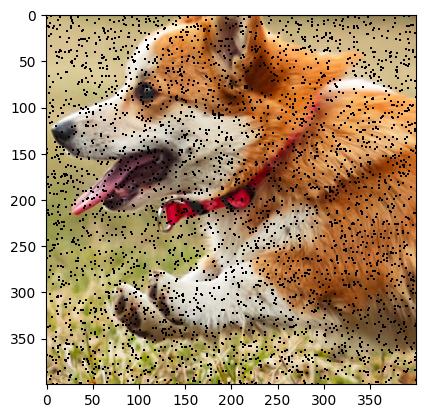

In [45]:
img_array = img.cpu().detach().to(dtype=torch.float32).numpy()
np.random.seed(42)
# Generate random indices for 900 points
random_indices = np.random.randint(0, img_array.shape[0], size=(3600, 2))

# Set the selected points to NaN
img_array[random_indices[:, 0], random_indices[:, 1], :] = np.nan

# Display the modified image
plt.imshow(img_array / 255)
plt.show()

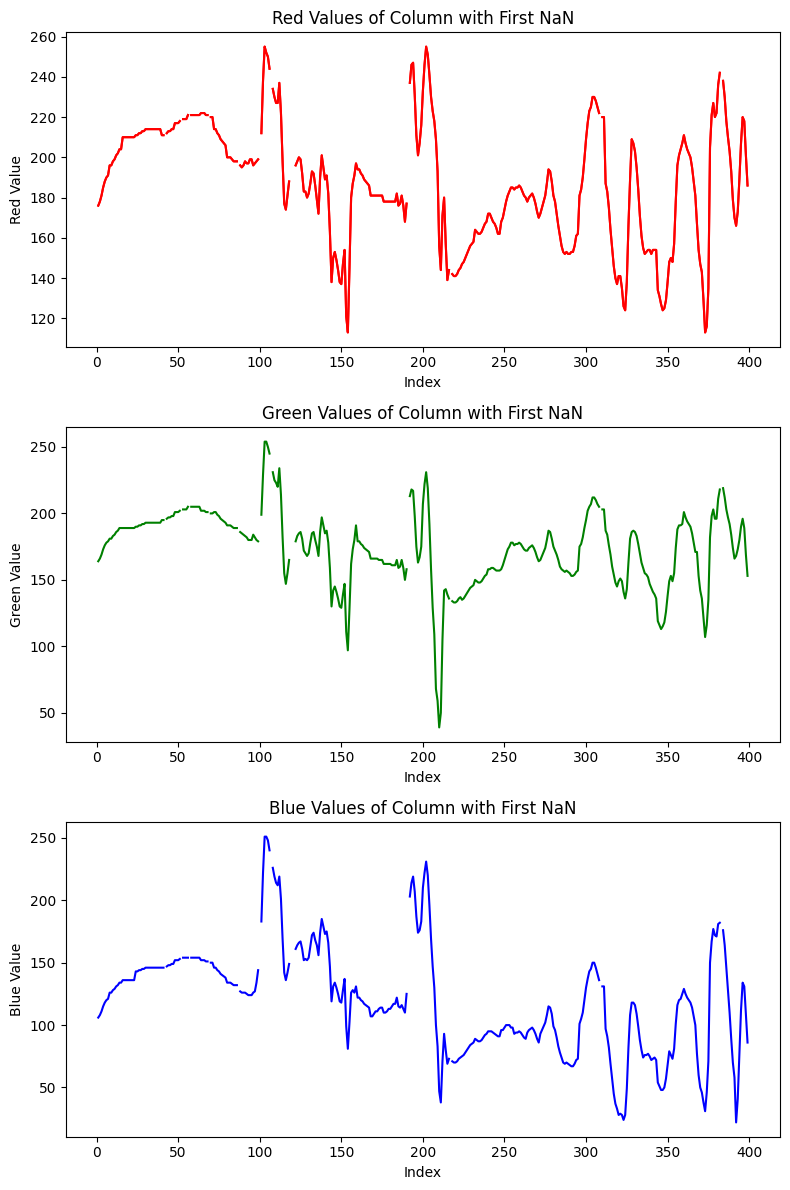

<Figure size 640x480 with 0 Axes>

In [46]:
import matplotlib.pyplot as plt

# Find the column index where the first NaN value occurs
column_index = torch.where(torch.isnan(torch.tensor(img_array)))[1][0]

# Get the red values of the column
red_values = torch.tensor(img_array[:, column_index, 0])
# Get the green values of the column
green_values = torch.tensor(img_array[:, column_index, 1])
# Get the blue values of the column
blue_values = torch.tensor(img_array[:, column_index, 2])

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plot the red values
axs[0].plot(red_values, color='red')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Red Value')
axs[0].set_title('Red Values of Column with First NaN')
# Plot the red values with missing values as black
axs[0].plot(red_values, color='red')
axs[0].scatter(torch.where(torch.isnan(red_values))[0], red_values[torch.isnan(red_values)], color='black')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Red Value')
axs[0].set_title('Red Values of Column with First NaN')

# Plot the green values with missing values as black
axs[1].plot(green_values, color='green')
axs[1].scatter(torch.where(torch.isnan(green_values))[0], green_values[torch.isnan(green_values)], color='black')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Green Value')
axs[1].set_title('Green Values of Column with First NaN')

# Plot the blue values with missing values as black
axs[2].plot(blue_values, color='blue')
axs[2].scatter(torch.where(torch.isnan(blue_values))[0], blue_values[torch.isnan(blue_values)], color='black')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Blue Value')
axs[2].set_title('Blue Values of Column with First NaN')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

# Plot the green values
axs[1].plot(green_values, color='green')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Green Value')
axs[1].set_title('Green Values of Column with First NaN')

# Plot the blue values
axs[2].plot(blue_values, color='blue')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Blue Value')
axs[2].set_title('Blue Values of Column with First NaN')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


In [48]:
## for 1 colour train the model

A = torch.tensor(img_array).clone().detach().to(torch.float32).to(device)
k = 180     # Here, k should be very very small than A.shape[0] and A.shape[1] 
lambda_reg = 0.12  # regularization parameter

# Factorize each color channel separately
W_r, H_r = factorize(A[:, :, 0], k, device, lambda_reg)
W_g, H_g = factorize(A[:, :, 1], k, device, lambda_reg)
W_b, H_b = factorize(A[:, :, 2], k, device, lambda_reg)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


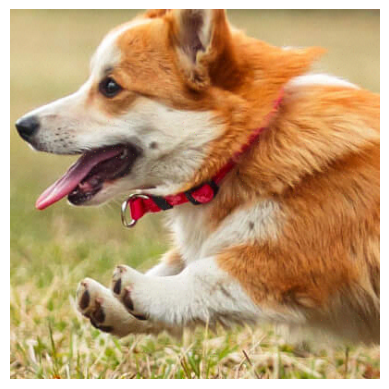

In [49]:
# Plot the reconstructed image

# Multiply W_r with H_r for the red channel
red_img = W_r @ H_r

# Multiply W_g with H_g for the green channel
green_img = W_g @ H_g

# Multiply W_b with H_b for the blue channel
blue_img = W_b @ H_b

# Combine the red, green, and blue channels to form the final image
final_img = np.stack([red_img.cpu().detach().numpy(), green_img.cpu().detach().numpy(), blue_img.cpu().detach().numpy()], axis=-1)

# Display the image
plt.imshow(final_img/255)
plt.axis('off')
plt.show()


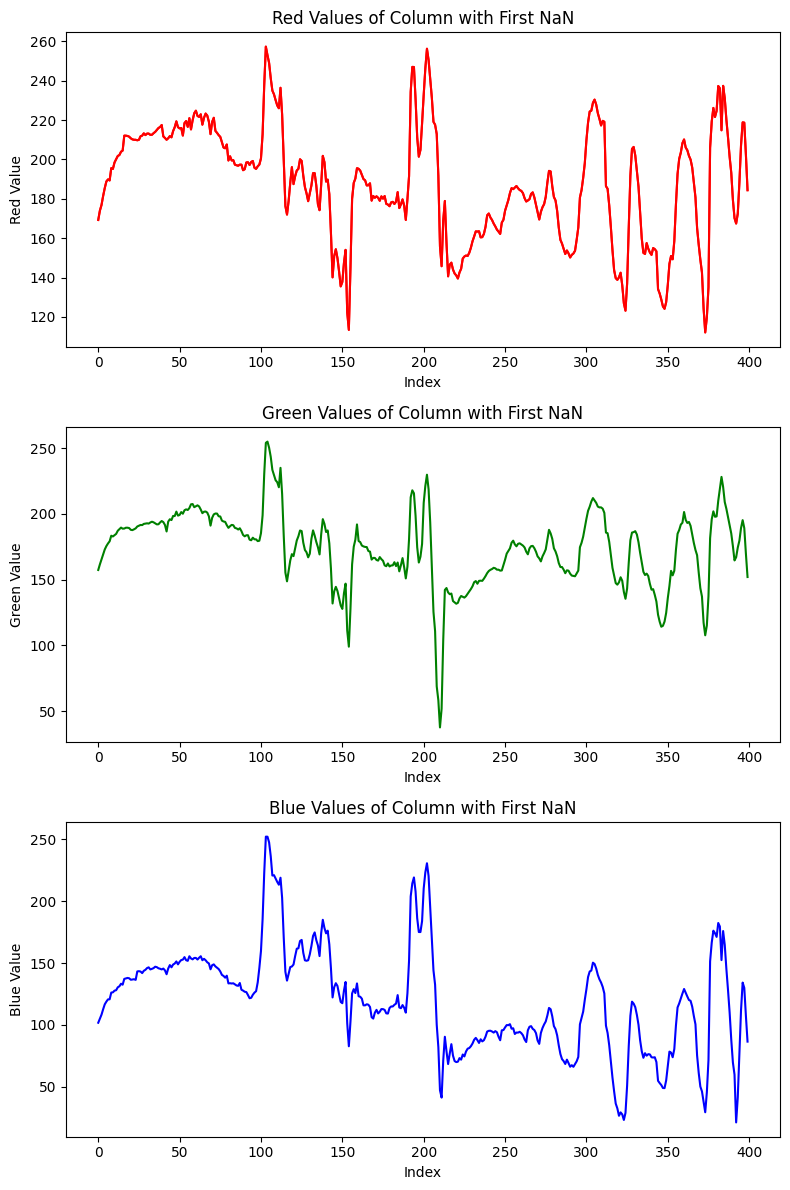

<Figure size 640x480 with 0 Axes>

In [50]:
import matplotlib.pyplot as plt

# Find the column index where the first NaN value occurs
column_index = torch.where(torch.isnan(torch.tensor(img_array)))[1][0]

# Get the red values of the column
red_values = (red_img[:, column_index]).cpu().detach().numpy()
# Get the green values of the column
green_values = (green_img[:, column_index]).cpu().detach().numpy()
# Get the blue values of the column
blue_values = (blue_img[:, column_index]).cpu().detach().numpy()

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plot the red values
axs[0].plot(red_values, color='red')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Red Value')
axs[0].set_title('Red Values of Column with First NaN')
# Plot the red values with missing values as black
axs[0].plot(red_values, color='red')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Red Value')
axs[0].set_title('Red Values of Column with First NaN')

# Plot the green values with missing values as black
axs[1].plot(green_values, color='green')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Green Value')
axs[1].set_title('Green Values of Column with First NaN')

# Plot the blue values with missing values as black
axs[2].plot(blue_values, color='blue')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Blue Value')
axs[2].set_title('Blue Values of Column with First NaN')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

# Plot the green values
axs[1].plot(green_values, color='green')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Green Value')
axs[1].set_title('Green Values of Column with First NaN')

# Plot the blue values
axs[2].plot(blue_values, color='blue')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Blue Value')
axs[2].set_title('Blue Values of Column with First NaN')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


# Metrics:

In [51]:
import numpy as np

# Convert the predicted image (A) and the original image (img) to numpy arrays
predicted_image = final_img
original_image = img.detach().cpu().numpy()

# Calculate the squared difference between the predicted and original images
squared_diff = np.square(predicted_image - original_image)

# Calculate the mean squared difference
mean_squared_diff = np.mean(squared_diff)

# Calculate the RMSE by taking the square root of the mean squared difference
rmse = np.sqrt(mean_squared_diff)

# Print the RMSE
print("RMSE:", rmse)


RMSE: 2.1262982


In [52]:
import numpy as np

def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    max_pixel = np.max(img1)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

psnr = calculate_psnr(final_img, np.array(img))
print("Peak Signal-to-Noise Ratio (PSNR):", psnr)


Peak Signal-to-Noise Ratio (PSNR): 41.95291042327881
